# Lab #3. Minimizing Large Sums

by Dominik Csiba and Peter Richtarik

The purpose of this lab will be to fool around with an efficient randomized algorithm for <i>minimizing finite sums</i>. In particular, we will be solving the L2-regularized ERM (empirical risk minimization) problem, namely 

$$\min_{w\in \mathbb{R}^d} \left\{ P(w) \equiv \frac{1}{n}\sum_{i=1}^n \phi_i(X_i^T w) + \frac{\lambda}{2}\|w\|_2^2 \right\},$$
using Dual-Free SDCA (dfSDCA) [1, 2]. 

The meaning of the terms above:
- $w\in \mathbb{R}^d$ is a linear predictor,
- $X_1,\dots,X_n \in \mathbb{R}^{m\times d}$ are training examples (in this code we will assume that $m=1$ and hence the examples are simply just vectors),
- $\phi_i:\mathbb{R}^d \to \mathbb{R}$ is the loss incurred on example $i$ (label associated with example $i$ is already incorporated in the definition of $\phi_i$; this why the function $\phi_i$ has a subscript),
- $\lambda>0$ is a regularization parameter (typically, $\lambda=\frac{1}{n}$),
- $P$ is the regularized empirical risk. 


$\textbf{Assumption 1.}$ The loss functions $\phi_i:\mathbb{R}^m\mapsto \mathbb{R}$, $i=1,\dots,n$, are $\tfrac{1}{\gamma}$-smooth. That is, for all $u,v\in \mathbb{R}^m$ the following inequality holds:
$$\| \nabla \phi_i(u) - \nabla \phi_i(v) \|_2 \leq \frac{1}{\gamma}\|u-v\|_2.$$
This is equivalent to requiring that for all $u,v\in \mathbb{R}^m$ one has
$$ \phi_i(u+v) \leq \phi_i(u) + (\nabla \phi_i(u))^\top v + \frac{1}{2\gamma}\|v\|_2^2.$$

$\textbf{Assumption 2.}$  The loss functions $\phi_i:\mathbb{R}^m \mapsto \mathbb{R}$, $i=1,\dots,n$, are convex. That is, for all $u,v\in \mathbb{R}^m$:

$$\phi(u) + (\nabla \phi_i(u))^\top v \leq \phi_i(u+v).$$

The standard SDCA (Stochastic Dual Coordinate Ascent) algorithm, as its name indicates, can be interreted as applying Stochastic/Randomized Coordinate Descent [3] to the Fenchel dual of the ERM problem. The dual problem is naturaly a concave maximization problem, and hence the word "ascent" is used instead of "descent". However, we have seen that dfSDCA is <i>not</i> motivated nor analyzed via the dual problem, and in this sense, the method is <i>dual-free</i>.

- [1] S. Shalev-Shwartz. SDCA without duality, <i>arXiv:1502.06177</i>, 2015
- [2] D. Csiba and P. Richtarik. Primal method for ERM with flexible mini-batching schemes and non-convex losses,
<i>arXiv:1506.02227</i>, 2015
- [3] P. Richtarik and M. Takac. Iteration complexity of randomized block-coordinate descent methods for minimizing a composite function, <i>Mathematical Programming</i> 144(2):1-38, 2014 (arXiv:1107.2848)




## Step 1 - Preliminary stuff

### Step 1.1 - Load a package for plotting 

We first load a package for plotting: <b>PyPlot</b>.

### Step 1.2 - Load a package for sampling from a probability distribution

We then include the  package <b>probability_tree.jl</b> with functions that will be useful for sampling from a non-uniform distribution from a finite set $[n]:=\{1, \dots, n\}$. In the lecture, we have considered <i>arbitrary samplings</i>, i.e., arbitrary set-valued mappings with values being the subsets of $[n]$. However, the package <b>probability_tree.jl</b> only implements samplings of  the form

$$\mathbf{P}(S_t = \{i\}) = p_i,$$

where $p_i>0$ for all $i\in [n]$ and $\sum_{i=1}^n p_i = 1$. In particular, the package <b>probability_tree.jl</b> contains two  routines:
- <b>PTCreate</b> - with input being the weights $p$ and output being an array which we call a probability tree, 
- <b>PTSample</b> - with inpit being a probability tree and and output being a random integer $i$ with probability $p_i$.

### Step 1.3 - Load a package for loading data from an external file

Finally, the package <b>load_matricies.jl</b> contains two routines:
- <b>ReadLIBSVM</b> - reads a dataset in LIBSVM format, inputs the filename, shape and a boolean <i>classification</i> indicating whether the dataset is for regression or classification, and outputs the matrix and labels
- <b>ReadData</b> - reads a dataset in a standard format, inputs the filename and a boolean <i>classification</i> indicating whether the dataset is for regression or classification, and outputs the matrix and labels

The data has to be stored in the folder "data".

### Step 1.4 - Operator overloading

We will also overload the $\cdot$ operator so that it outputs a scalar as a result of an inner product of a vecor represented as a sparse matrix and a vector represented as an array. These operations will be used often. The default type of the result, without the operator overloading, is a sparse matrix, which would be inconvenient.

In [2]:
using PyPlot

include("probability_tree.jl")

include("load_matrices.jl")

⋅(x::SparseMatrixCSC{Float64, Int64}, y::Array{Float64,1}) = (x'*y)[1]
⋅(x::SparseMatrixCSC{Float64, Int64}, y::SparseMatrixCSC{Float64, Int64}) = (x'*y)[1]

dot (generic function with 9 methods)

## Step 2 - Loss functions

We assume that the $n$ examples $X_1,\dots,X_n \in \mathbb{R}^d$ are stored as columns of a $d\times n$ matrix $X$ (technically, a "sparse matrix" in Julia). We also assume that the associated labels $y_1,\dots,y_n\in \mathbb{R}$ are stored as entries of a vector  $y\in \mathbb{R}^n$ (technically, an "array" in Julia).

In particular, we work with the quadratic loss:

$$ \phi_i(t) = \frac{1}{2\gamma} (t - y_i)^2, \qquad  \nabla \phi_i(t) = \frac{1}{\gamma} (t-y_i), \qquad \phi_i(X_i^\top w) = \frac{1}{2\gamma} (X_{i}^\top w - y_i)^2, \qquad \nabla \phi_i(X_i^\top w) = \frac{1}{\gamma} (X_i^\top w - y_i).$$

It can be verified that $\phi_i$ is indeed $\tfrac{1}{\gamma}$-smooth and convex. 

We now define a function <b>Loss_quadratic</b> whose output will be a touple:
- function <b>P(w)</b> 
- function <b>g(w,i)</b> (which evaluates $\nabla \phi_i(X_i^\top w)$). 

Indeed, functions are first-class citizens in Julia. They can be an output of other functions. This is great, since it will allow us to write a single dfSDCA code which will call generic functions $P$ and $g$. Whenever we change these functions, the code runs with these new functions without any changes. This makes it easy to write flexible optimization code in Julia.


### Exercise A: Logistic Regression

Replace the three ??? signs in the <b>Loss_logistic</b> function below by suitable code so that the  function works analogously to the <b>Loss_quadratic</b> function.  

<i> Hint: </i> The logistic loss is defined as

$$ \phi_i(t) = \frac{4}{\gamma} \log \left(1 + e^{y_i t} \right)$$

and its derivative is

$$\nabla \phi_i(t) = \frac{4 y_i}{\gamma \left(1+ e^{-y_i t}\right)} \enspace .$$

Again, it can be verified that $\phi_i$ is indeed $\tfrac{1}{\gamma}$-smooth and convex. 

In [21]:
function Loss_quadratic(X::SparseMatrixCSC, y::Array{Float64,1}, γ::Float64, λ::Float64)
    n = size(X)[2]
    f(w, i) = 1/(2γ)*(X[:,i]⋅w - y[i])^2 # the overloading is used here
    g(w, i) = 1/γ*(X[:,i]⋅w - y[i]) # and here
    P(w)    = 1/n*sum([f(w,i) for i=1:n]) + λ/2*w⋅w
    return (g, P)
end

function Loss_logistic(X::SparseMatrixCSC, y::Array{Float64,1}, γ::Float64, λ::Float64)
    n = size(X)[2]
    f(w, i) = ???
    g(w, i) = ???
    P(w)    = ???
    return(g, P)
end

LoadError: syntax: colon expected in "?" expression
while loading In[21], in expression starting on line 12

## Step 3 - The dfSDCA Algorithm

Recall that the dfSDCA algorithm looks as follows:

Initialize:
- Choose a sampling (random set-valued mapping) $\hat{S}$ 
- Compute $p_i = \mathbf{P}(i \in \hat{S})$
- Compute "stepsize" parameters $v_1,\dots,v_n$ satisfying the ESO inequality
$$P \circ X^\top X \preceq Diag(p \circ v),$$
where $v = (v_1,\dots,v_n)$, $p=(p_1,\dots,p_n)$ and $P$ is the $n\times n$ "probability" matrix associated with $\hat{S}$. That is, $P$ is the matrix with $(i,j)$ entry equal to $\mathbf{P}(\{i,j\}\subseteq \hat{S})$. Note that we are now using $P$ both for the probability matrix and the primal objective function. This is too bad, but then no confusion should be caused by this! This form of ESO only makes sense if $m=1$; for $m>1$, the correct ESO inequality looks a bit different [2]. 
- Set 
$$\theta =  \min_{i}  \frac{p_i \lambda \gamma n}{v_i + \lambda \gamma n}$$
- Choose initial "dual" variables $\alpha_1^{0}, \dots, \alpha_n^{0} \in \mathbb{R}^m$
- Set 
$$w^{0} = \frac{1}{\lambda n}\sum_{i=1}^n X_i\alpha_i^{0}$$

For $t \geq 0$ repeat:
- Choose a random set (minibatch) $S_t\subseteq \{1,2,\dots,n\}$ of examples, with $S_t\sim \hat{S}$ 
- For $i \in S_t$ do (possibly in parallel): 
$$\alpha_i^{t+1} = \left( 1- \frac{\theta}{p_i} \right) \alpha_i^{t} + \frac{\theta}{p_i}(-\nabla\phi_i(X_i^\top w^{t}))$$
- Update the main variable:
$$w^{t+1} = w^{t} - \sum_{i\in S_t} \frac{\theta}{\lambda n p_i}  X_i(\nabla\phi_i(X_i^\top w^{t}) + \alpha_i^{t})$$


Now we write a Julia function called <b>dfSDCA</b> which implements the algorithm in the special case when $m=1$ and $|\hat{S}|=1$ with probability 1. It will have the following input variables:
- $X$ = $d\times n$ data matrix
- $g$ = function evaluating $\phi_i(X_i^\top w)$
- $P$ = the objective function
- $p$ = an array representing a discrete probability distribution over $\{1,2,\dots,n \}$
- $T$ = number of iterations
- $\gamma$ = smoothness parameter (we assume $\phi_i$ is $1/\gamma$-smooth)
- $\lambda$ = strong-convexity parameter
- <i>track</i> = a boolean deciding whether we want to output function values or the primal variable $w^{T}$
- <i>AlgLabel</i> = label for the print outputs during the run of the algorithm
- <i>progress</i> = a boolean value indicating whether the progress is shown in the console or not

### Exercise B

There are 5 places with questions marks ??? in the dfSDCA code below. Replace them with the correct code.

In [ ]:
function dfSDCA(X::SparseMatrixCSC, g::Function, P::Function, p::Array{Float64,1}, T::Int64, 
    γ::Float64, λ::Float64, track::Bool, AlgLabel::ASCIIString, progress::Bool)
    
(d,n) = size(X)
    
if track
        Pvalue = zeros(ifloor(T/n)+1) # prepares the array of function values
end
     
v = ???

θ = minimum(p*λ*γ*n./(v + λ*γ*n)) # step size

PT = ??? # creates the probability tree

α = zeros(n) # the starting points are set to zero vectors for simplicity
w = ???

for t=0:T

    if t % n == 0 # every n iterations store the function value and prints a message about progress
        if track
            Pvalue[t/n + 1] = P(w)
            if progress
                println(AlgLabel, ":  #passes $(t/n), function value: $(Pvalue[t/n + 1])")
            end
        else
            if progress
                println(AlgLabel, ":  #passes $(t/n)")
            end
        end
    end

    i = PTSample(PT) # sample a coordinate according to distribution p
    Δ = g(w,i) + α[i] # store the update as Δ
    α[i] -= ???
    w -= (X[:,i]*θ*Δ) / (???) # vector - matrix = matrix
    w = vec(w) # matrix -> vector 
end

println( AlgLabel ," finished!")

if track # return function values or w, dependig on track
    return Pvalue
else
    return w
end
    
end

## Step 4 - Plotting functions

We now write 2 functions which will be used to visualize the results. 

Function <b>ShowConvergence</b> takes the following input:
- <i>Pvalues</i> - a tuple of function value arrays
- <i>AlgLabels</i> - a tuple of algorithm labels, for legend
- <i>Pstar</i> - the optimal function value

Function <b>dfSDCACompare</b> is used for comparing the behavior of several variants of <b>dfSDCA</b> in a single plot. The variants differ in the choice of the probability vector $p$. The function first finds the optimal function value (by running the <b>dfSDCA</b> method for 60 passes over data), and then uses the objective function value found in lieu of the true minimum. This is used in order to plot $P(w^t) - P(w^*)$  on the $y$ axis in logarithmic scale.

Input:

- $X$ = data matrix
- $g$ = function evaluating $\phi_i(X_i^\top w)$
- $P$ = the primal objective function
- $T$ = number of iterations
- $\gamma$ = smoothness parameter
- $\lambda$ = strong-convexity parameter
- $plist$ = a tuple of probability distributions
- <i>AlgLabel</i> = tuple of labels for the print outputs during the run of the algorithm and for the legend
- <i>progress</i> = a boolean indicating, whether the progress is shown in the console

In [ ]:
function ShowConvergence(Pvalues, AlgLabels, Pstar::Float64)    
    ax = axes()
    for i=1:length(Pvalues)
        plt[:plot](0:(length(Pvalues[i])-1), abs(Pvalues[i]-Pstar), "-", linewidth=3.0, label=AlgLabels[i])
    end
    legend(loc="upper right")
    ylabel(L"$P(w^{t}) - P(w^\star)$", fontsize=20)
    xlabel("passes over data")
    ax[:set_yscale]("log")
    plt[:show]()
end

function dfSDCACompare(X::SparseMatrixCSC, g::Function, P::Function, 
    T::Int64, γ::Float64, λ::Float64, plist, AlgLabel, progress::Bool)
    v = float([X[:,i]⋅X[:,i] for i=1:n])
    p_imp = v + λ*γ*n
    p_imp = p_imp/sum(p_imp)
    wstar = dfSDCA(X, g, P, p_imp, 2T, γ, λ, false, "Optimal value", progress)
    Pstar = P(wstar)
    Pvalues = [dfSDCA(X, g, P, plist[i], T, γ, λ, true, AlgLabel[i], progress) for i = 1:length(plist)]
    ShowConvergence(Pvalues, AlgLabel, Pstar)
end 

## Step 5 - Run the method on a problem with synthetic data

### Step 5.1 - We first generate a random problem

In [24]:
n = 10000
d = 100
X = sprand(d, n, 0.1)
y = rand(n)
γ = 1.0
λ = 1/n
g, P = Loss_quadratic(X,y,γ,λ)

(g,P)

### Step 5.2 - Now we define three different probability distributions

These will correspond to three different versions of the dfSDCA method.

In [25]:
p1 = ones(n)/n
v = float([X[:,i]⋅X[:,i] for i=1:n]) # julia is having difficulties with arrays of type "Any"
p2 = v + n*λ*γ
p2 = p2/sum(p2)
p3 = 0.1 + rand(n)
p3 = p3/sum(p3)

10000-element Array{Float64,1}:
 4.0644e-5  
 0.000156757
 0.000118708
 0.00015125 
 0.000132788
 6.73287e-5 
 6.15532e-5 
 5.13981e-5 
 0.000104581
 0.000149406
 3.26371e-5 
 4.90531e-5 
 7.91167e-5 
 ⋮          
 8.13125e-5 
 0.000148301
 2.43018e-5 
 0.000158793
 0.000180867
 4.93192e-5 
 0.000124565
 9.74629e-5 
 3.56497e-5 
 0.000150385
 4.45186e-5 
 0.000132328

### Step 5.3 - We can now run the method

Optimal value finished!
dfSDCA-unif finished!
dfSDCA-imp finished!
dfSDCA-rand

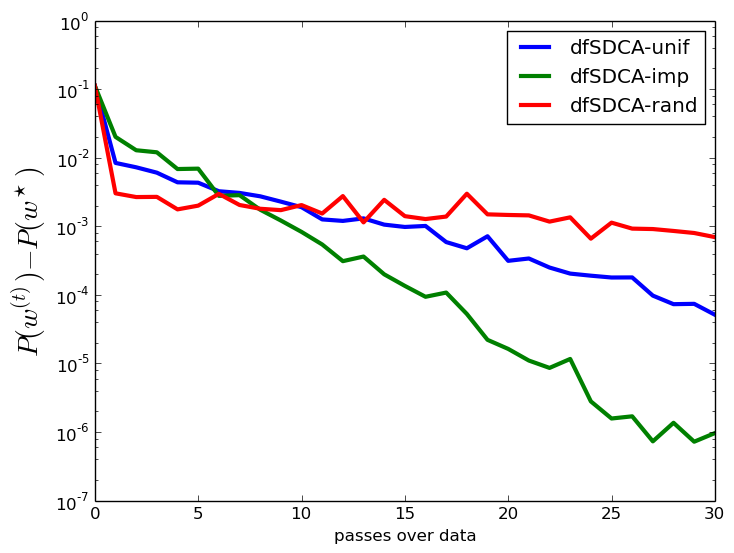

 finished!


In [26]:
dfSDCACompare(X, g, P, 30n, γ, λ, (p1,p2,p3), ("dfSDCA-unif", "dfSDCA-imp", "dfSDCA-rand"), false)

## Step 6 - Run the method on a problem with real data

Optimal value:  #passes through data 0.0
Optimal value:  #passes through data 1.0
Optimal value:  #passes through data 2.0
Optimal value:  #passes through data 3.0
Optimal value:  #passes through data 4.0
Optimal value:  #passes through data 5.0
Optimal value:  #passes through data 6.0
Optimal value:  #passes through data 7.0
Optimal value:  #passes through data 8.0
Optimal value:  #passes through data 9.0
Optimal value:  #passes through data 10.0
Optimal value:  #passes through data 11.0
Optimal value:  #passes through data 12.0
Optimal value:  #passes through data 13.0
Optimal value:  #passes through data 14.0
Optimal value:  #passes through data 15.0
Optimal value:  #passes through data 16.0
Optimal value:  #passes through data 17.0
Optimal value:  #passes through data 18.0
Optimal value:  #passes through data 19.0
Optimal value:  #passes through data 20.0
Optimal value:  #passes through data 21.0
Optimal value:  #passes through data 22.0
Optimal value:  #passes through data 23.0
Op

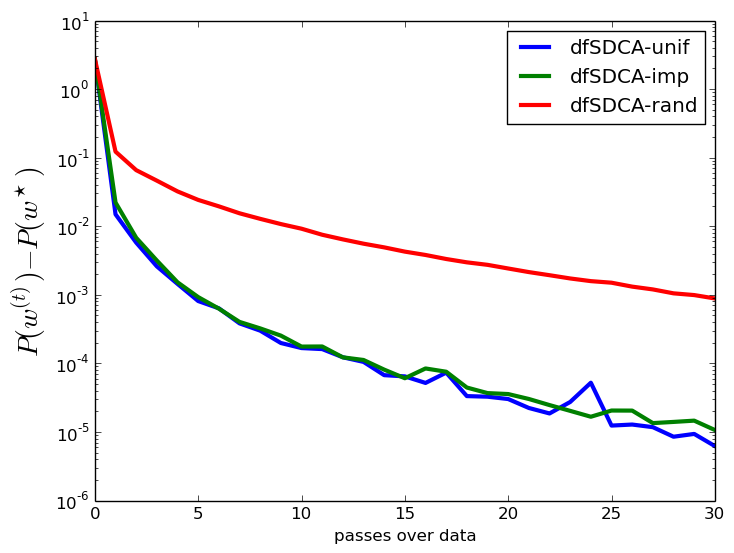

:  #passes through data: 29.0, function value: 0.023749162643019635
dfSDCA-rand:  #passes through data: 30.0, function value: 0.023643017477028072
dfSDCA-rand finished!


In [28]:
X,y = ReadData("mushrooms", true)
#X,y = ReadLIBSVM("ijcnn1.tr", (49990,22) ,true)

d,n = size(X)
γ = 1.0
λ = 1/n
g, P = Loss_logistic(X,y,γ,λ)

p1 = ones(n)/n
v = float([X[:,i]⋅X[:,i] for i=1:n])
p2 = v + λ*γ*n
p2 = p2/sum(p2)
p3 = 0.1 + rand(n)
p3 = p3/sum(p3)

dfSDCACompare(X, g, P, 30n, γ, λ, (p1,p2,p3), ("dfSDCA-unif", "dfSDCA-imp", "dfSDCA-rand"), true)

## Step 7 - Further Exercises

### Exercise C

Write a new function, <b>dfSDCA10</b>, which always updates a set of $10$ variables $\alpha_i$, chosen uniformly at random. That is, $|S_t|=10$ with probability 1, and all such subsets of cardinality 10 are equaly likely chosen. Make sure the stepsize parameters $v$ are chosen correctly, following theoretical recommendation.

### Exercise D

Write a new function, <b>dfSDCAall</b>, which in each iteration updates all variables $\alpha_i$. This method is deterministic. Compare its behavior with dfSDCA with uniform sampling of a single "dual" variable in a single plot.

### Exercise E

Code up the stochastic gradient descent algorithm (with a fixed stepsize). For a range of stepsizes, plot its behavior (as it is done for dfSDCA in the above plots). Compare with dfSDCA.

### Exercise F

Code up any (or all) of the special instances of the general randomized method for solving linear systems we discussed during the course:
- Randomized Kaczmarz
- Randomized Coordinate Descent
- Randomized Newton
- Randomized Gaussian Descent

Generate some random problems and play with the solver(s).

### *Exercise G

Find a convex quadratic function $f: \mathbb{R}^3\mapsto \mathbb{R}$ for which the Randomized Newton method with $|C|=2$ converges 1000 times faster than Randomized Newton with $|C|=1$. By convergence we mean $f(x^t)-f(x^*)\leq 10^{-6}$.

### *Exercise H

Does it make sense to update the probability vector $p$ throughout the iterations of dfSDCA? Can you come up with an adaptive strategy that leads to a faster method in runtime? 